# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry at Solar M/H and C/O

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done in [Mukherjee et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220814317M/abstract) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)


What you will need to download to use this tutorial: 

1. [Download the m+0.0_co1.0.data.196](https://zenodo.org/record/6708165/files/m%2B0.0_co1.0.data.196.tar.zip?download=1) (28.4 Mb) 1060 196 Correlated-K table from Roxana Lupu to be used by the climate code for opacity. **This is an older version of the C-K tables used in the first two tutorials and you will only need the solar C/O and solar M/H file as we have not yet enabled any chemical composition**
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can have a simple starting guess 
3. (Optional)[Download](http://perso.ens-lyon.fr/isabelle.baraffe/ATMO2020/ATMO_2020_models.tar.gz) the [Phillips et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P/abstract) models if you want to benchmark the diseq runs with an independent code



In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ck_db = f'/Users/nbatalh1/Documents/data/m+0.0_co1.0.data.196'

#sonora bobcat cloud free structures file
sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0/'
phillips_2020_db = '/Users/nbatalh1/Documents/data/ATMO_2020_models/'

## Starting up the Run

In [3]:
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

This should all look familiar as it is the same steps taken for the regular brown dwarf run.

In [4]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation 

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation  

teff= 700 # Effective Temperature of your Brown Dwarf in K
grav = 3160 # Gravity of your brown dwarf in m/s/s 

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

## Initial T(P)  Guess 

All same as before

In [5]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

#Pmin = 1e-4 #bars
#Pmax = 500 #bars
#pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)
kz = temp_bobcat*0 + 1e4
self_consistent_kzz = False

## Initial Convective Zone Guess

This is all the same as the original Brown Dwarf tutorial. Here we will be a little more conservative with our convective zone guess as this is our first Disequilibrium run. 

In [6]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 86 # top most level of guessed convective zone (we are just guessing nlevel-5)
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

All the same here as well. 

In [7]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat, 
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

## Run the Climate Code with disequilibrium chemistry

### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$: 
 
 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf))

**New code parameters**: 

0. `diseq_chem=True` : First we will turn on disequilibrium chemistry
1. `self_consistent_kzz` : (True/False) This solves self consistently for 
2. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
3. `kz` : constant value if `self_consistent_kzz=False`

### On the fly mixing 

In [Mukherjee et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220814317M/abstract) on-the-fly mixing of CO, CH4, NH3, and H2O was considered. There are some important assumptions for version 1 that the user needs to be aware: 

1. We only allow solar C/O and solar M/H 
2. Only CO, CH4, NH3, and H2O will be mixed on the fly. 

Soon we will make this more flexible but want to make sure that V1 of the climate code is well-behaved for users before we open it up to all gases. 

In [8]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True,
                    diseq_chem=True, kz=kz)

Iteration number  0 , min , max temp  220.37853535863343 2157.2023051116967 , flux balance  1.4321186537961034e-06
Iteration number  1 , min , max temp  220.1017634936712 2157.186839743511 , flux balance  3.6298329124114754e-10
In t_start: Converged Solution in iterations  1
Big iteration is  220.1017634936712 0
Iteration number  0 , min , max temp  220.5273270433216 2157.9067469165043 , flux balance  3.509789314204546e-08
In t_start: Converged Solution in iterations  0
Profile converged
Iteration number  0 , min , max temp  220.58432395171542 2157.9960553146507 , flux balance  4.159136319763609e-09
In t_start: Converged Solution in iterations  0
Big iteration is  220.58432395171542 0
Iteration number  0 , min , max temp  220.5915905689744 2158.005848583862 , flux balance  9.313327906959213e-10
In t_start: Converged Solution in iterations  0
Profile converged
Iteration number  0 , min , max temp  220.5927368754032 2156.4807243401556 , flux balance  -6.426656068376268e-09
In t_start: Co

Profile converged
YAY ! ENDING WITH CONVERGENCE
PH3 quenched at level 76


In [11]:
out.keys()

dict_keys(['diseq_out', 'pressure', 'temperature', 'ptchem_df', 'dtdp', 'cvz_locs', 'flux', 'all_profiles', 'spectrum_output'])

## Benchmark with Phillips et al 2020
With all model runs it is important to benchmark with previously published models, especially with an independent model. We can benchmark the PICASo runs with the work from [Phillips et al 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P/abstract) to create the ATMO 2020 grid. 

Text(0.5, 1.0, 'T$_{\\rm eff}$= 700 K, log(g)=5.5, K$_{\\rm zz}$=1e4')

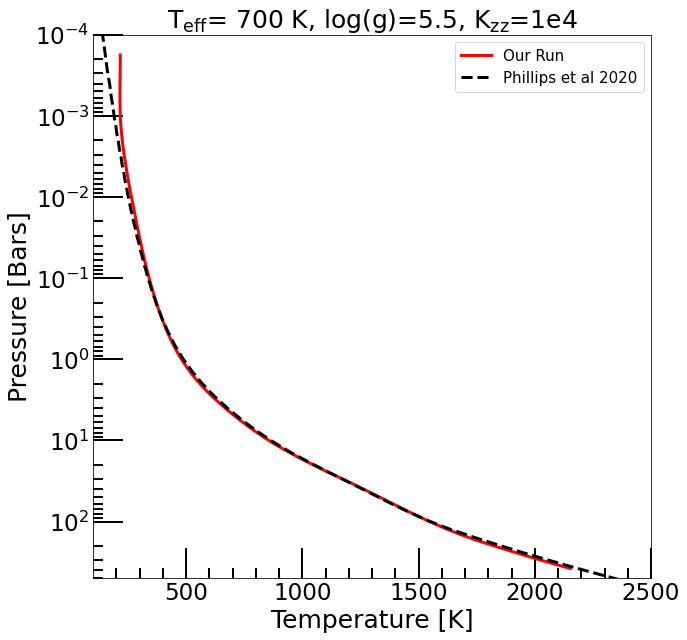

In [10]:
pphil_deq,tphil_deq = np.loadtxt(jdi.os.path.join(phillips_2020_db, 
                                              #phillips directory structre
                                             'atmosphere_models','NEQ_strong_compositions',
                                             'chem_T700_lg5.5_NEQ_strong.txt')
                                ,usecols=[1,2],unpack=True)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(100,2500)

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Our Run")

plt.semilogy(tphil_deq,pphil_deq,color="k",linestyle="--",linewidth=3,label="Phillips et al 2020")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 700 K, log(g)=5.5, K$_{\rm zz}$=1e4",fontsize=25)

